# African Tulip Detection for Samoa
This notebook uses data from 2023 to detect the African Tulip for Samoa and is a copy/derivative of the non-tree/tree layer notebook. This notebook utises a masked layer that consists of ~45 variables that are spectral and texture-based layers derived from the Planet SkySat multispectral image and elevation layers derived from the 2015/2016 LiDAR data. The layer was masked using a tree/non-tree layer.

This notebook is a derivative of the original notebook, and focuses on utilising a combination of both spectral and textural layers.

This layer will be used to derive training information for the ground countrol points, and then be used to train and predict the presence of the African Tulip using a Random Forest Model and XGBoost Model.

In [1]:
# install librariees
import os
import rasterio as rio
import numpy as np
import pandas as pd

import geopandas as gpd
from osgeo import osr
from osgeo import gdal, gdal_array

from rsgislib import zonalstats
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold
from sklearn.tree import DecisionTreeClassifier

In [2]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

##### Get list of names of feature datasets

In [3]:
# data in file path
fn = 'C:/Data/atulip/ws/subset_area/site0/spectral/feat_dataset/'
out_fn = 'C:/Data/atulip/ws/subset_area/site0/spectral/pre/'
# get list
file_ls = [f for f in os.listdir(fn) if os.path.isfile(os.path.join(fn, f))]

In [4]:
# generate filepaths for each file in the feature dataset
ls = []
for i in range(0,len(file_ls)):
    id = os.path.join(fn+file_ls[i])
    # print(id)
    ls.append(id)

##### Open raster stack of feature datasets
open new stack (or re-open previously crated stack), this must also then be reshaped

In [5]:
# open new stack (or re-open previously crated stack), this must also then be reshaped
with rio.open(os.path.join(out_fn+'stack.tif')) as src:
    # get metadata from dataset
    bcount = src.count
    tags = src.tags()
    stack_r = src.read()
    src_meta = src.profile

In [6]:
# rearrange shape of the image stack to train and predict on
img = np.transpose(stack_r,(1,2,0))
img.shape # must be col, row, band

(9423, 22127, 19)

##### Load and reshape masked stack feature dataset

In [7]:
# load in a mask image to make the image for prediction - skip if masked previously
with rio.open(os.path.join(out_fn+ 'masked_stack.tif')) as dt:
    X_masked_array = dt.read()
    bc = dt.count

In [8]:
# reshape numpy to match the image
X_array = np.transpose(X_masked_array,(1,2,0))
print(X_array.shape) # is a numpy ndarray

(9423, 22127, 19)


#### Calculate Mean Statistics for training data
Using rsgislib zonalstats (faster than rasterstats)

In [9]:
# file data file
vec_file = 'C:/Data/atulip/ws/subset_area/site0/training_data/'
lyr = 'gcp_prop.gpkg'

In [10]:
# open vector dataset
# read in training/testing data - with zonal statistics/pixel values
input_data = gpd.read_file(os.path.join(vec_file + lyr))
input_data.head() # preview shapefile

,Feature,class_id,blue,blue_laplacian,blue_maxd,b_var,gndvi,green,green_laplacian,green_maxd,...,nir,nir_laplacian,nir_maxd,n_var,red,redgreen,red_laplacian,red_maxd,r_var,geometry
0,African Tulip,1.0,132.0,288.0,529.0,0.0,0.857308,370.0,65244.0,6745.0,...,4816.0,61073.0,6595.0,12.0,337.0,-0.046676,4569.0,6745.0,0.0,POINT (417648.292 8468031.229)
1,African Tulip,1.0,489.0,288.0,898.0,0.0,0.589020,786.0,65275.0,3123.0,...,3039.0,62974.0,2889.0,3.0,796.0,0.006321,2266.0,3123.0,0.0,POINT (417808.243 8467342.295)
2,African Tulip,1.0,350.0,501.0,509.0,0.0,0.666945,799.0,64905.0,3793.0,...,3999.0,62239.0,3508.0,0.0,645.0,-0.106648,3505.0,3793.0,0.0,POINT (417997.783 8467241.584)
3,African Tulip,1.0,275.0,291.0,510.0,0.0,0.827332,585.0,65265.0,6413.0,...,6191.0,59737.0,6157.0,2.0,557.0,-0.024518,5600.0,6413.0,0.0,POINT (417728.569 8467852.090)
4,African Tulip,1.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,POINT (417989.324 8467659.639)


In [11]:
# review existing grid and drop rows where NAN values are present (often masked results)
input_data = input_data.dropna()

# write vec layer to folder
input_data.to_file(vec_file + 'gcp_stats_spec.gpkg')

##### Arrange training data (with stats alrady calculated)

In [12]:
# read in point data with stats already calculated 

input_data = gpd.read_file(vec_file + 'gcp_stats_spec.gpkg')
input_data.head()

,Feature,class_id,blue,blue_laplacian,blue_maxd,b_var,gndvi,green,green_laplacian,green_maxd,...,nir,nir_laplacian,nir_maxd,n_var,red,redgreen,red_laplacian,red_maxd,r_var,geometry
0,African Tulip,1.0,132.0,288.0,529.0,0.0,0.857308,370.0,65244.0,6745.0,...,4816.0,61073.0,6595.0,12.0,337.0,-0.046676,4569.0,6745.0,0.0,POINT (417648.292 8468031.229)
1,African Tulip,1.0,489.0,288.0,898.0,0.0,0.589020,786.0,65275.0,3123.0,...,3039.0,62974.0,2889.0,3.0,796.0,0.006321,2266.0,3123.0,0.0,POINT (417808.243 8467342.295)
2,African Tulip,1.0,350.0,501.0,509.0,0.0,0.666945,799.0,64905.0,3793.0,...,3999.0,62239.0,3508.0,0.0,645.0,-0.106648,3505.0,3793.0,0.0,POINT (417997.783 8467241.584)
3,African Tulip,1.0,275.0,291.0,510.0,0.0,0.827332,585.0,65265.0,6413.0,...,6191.0,59737.0,6157.0,2.0,557.0,-0.024518,5600.0,6413.0,0.0,POINT (417728.569 8467852.090)
4,African Tulip,1.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,POINT (417989.324 8467659.639)


In [13]:
# drop columns that will not be used
grid_gdf = input_data.drop(columns = {'geometry', 'Feature'})
# rename column for class id
grid_gdf = grid_gdf.rename(columns = {'class_id':'class'})

In [14]:
grid_gdf.head()

,class,blue,blue_laplacian,blue_maxd,b_var,gndvi,green,green_laplacian,green_maxd,g_var,ndvi,nir,nir_laplacian,nir_maxd,n_var,red,redgreen,red_laplacian,red_maxd,r_var
0,1.0,132.0,288.0,529.0,0.0,0.857308,370.0,65244.0,6745.0,0.0,0.869202,4816.0,61073.0,6595.0,12.0,337.0,-0.046676,4569.0,6745.0,0.0
1,1.0,489.0,288.0,898.0,0.0,0.589020,786.0,65275.0,3123.0,0.0,0.584876,3039.0,62974.0,2889.0,3.0,796.0,0.006321,2266.0,3123.0,0.0
2,1.0,350.0,501.0,509.0,0.0,0.666945,799.0,64905.0,3793.0,0.0,0.722222,3999.0,62239.0,3508.0,0.0,645.0,-0.106648,3505.0,3793.0,0.0
3,1.0,275.0,291.0,510.0,0.0,0.827332,585.0,65265.0,6413.0,0.0,0.834914,6191.0,59737.0,6157.0,2.0,557.0,-0.024518,5600.0,6413.0,0.0
4,1.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.000000,-9999.0,-9999.0,-9999.0


In [15]:
# randomly select a proportion of data from the p2p gcp
grid_gdf['class'].value_counts()

class
1.0    349
2.0    334
Name: count, dtype: int64

In [16]:
# no longer needed
#class_other = grid_gdf[grid_gdf['class'] == 2.0]
#class_other.head()

#### Get Column indices and create class dictionary 
Prepare data for test/training

In [17]:
class_dict = {'African tulip':1, 'Other':2}
field = 'class'
# get column names from header
column_names = []
for col in grid_gdf.columns:
  column_names.append(col)

model_col_indices = [
    column_names.index(var_name) for var_name in column_names[1:]
]

print(model_col_indices)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [18]:
# convert variable names to scikit learn nomenclature
#X1 = grid_gdf.to_numpy()[:, model_col_indices] # numpy array
#y1 = grid_gdf.to_numpy()[:,0]

In [19]:
dfs = {}

# Insert data into a Pandas DataFrame, then split into features and labels
X = grid_gdf.drop(field, axis=1) # pandas dataframe
y = grid_gdf[[field]]

# Fit the standard scaler to all features
scaler = StandardScaler(with_mean=False)
scaler.fit(X);

for key, value in class_dict.items():
    print(key, value)
    # extract values for class from training data
    # create a pandas df for ease of use later
    df = grid_gdf.rename(columns={i:column_names[i] for i in range(0,len(column_names))}).drop(field, axis=1)
    # Scale the dataframe
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns)

    dfs.update({key:scaled_df})

African tulip 1
Other 2


## Feature Selection - Feature Importance from Training Samples
Get feature importance from feature datasets and select features

In [20]:
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [21]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, train_size = 0.7, random_state = 42, stratify = y
)

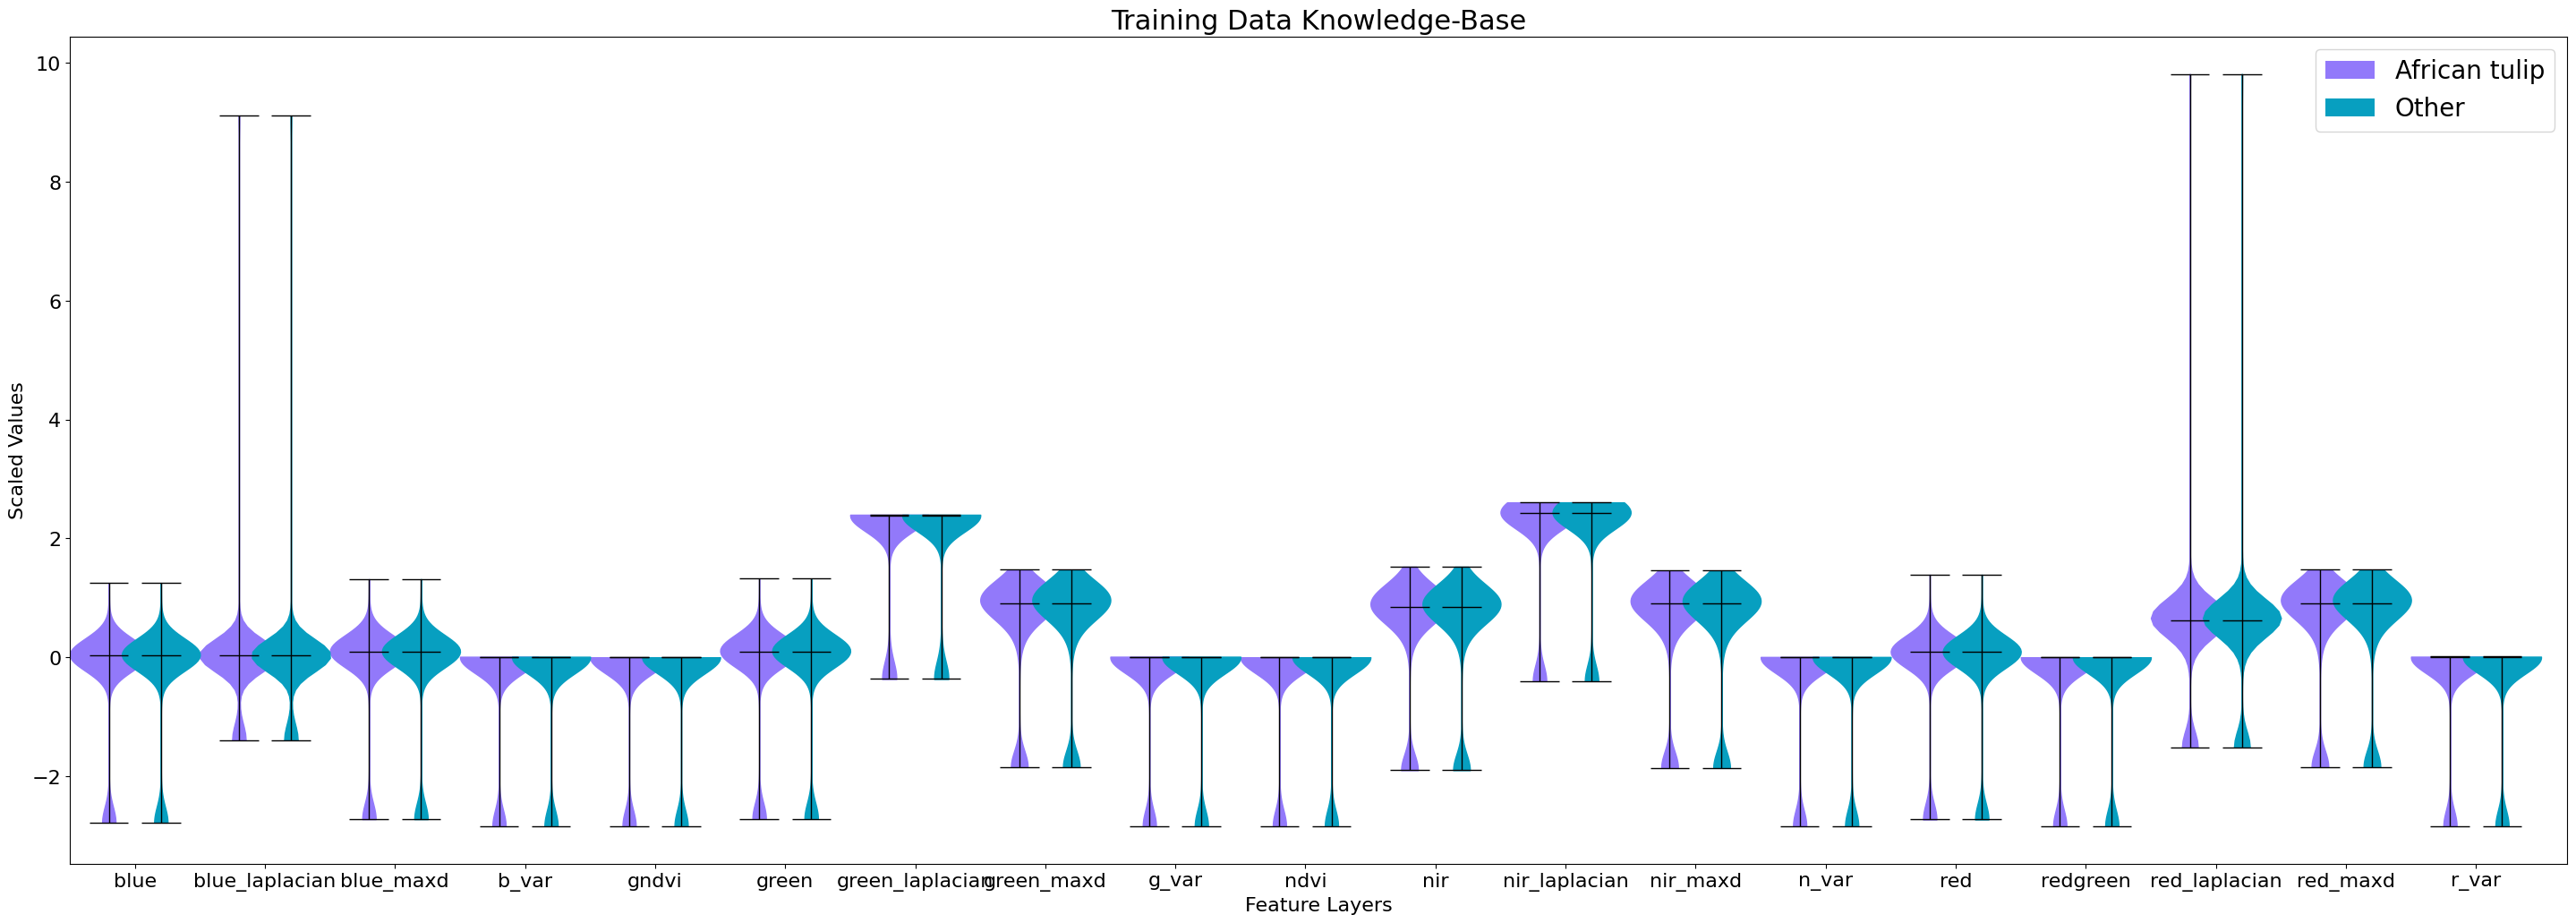

In [22]:
# Generate a random list of colors same length as num of classes (2 classes so 2 colours)
get_colors = lambda n: list(
    map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF), range(n)))
colors = get_colors(len(dfs))

# Generate list of offsets & widths for plotting
start = -0.2
end = 0.2
offsets = list(np.linspace(start, end, len(dfs)))
if len(dfs) == 2:
    width = 0.6
else:
    width = np.abs(offsets[0] - offsets[1])

# Create figure and axes
fig, ax = plt.subplots(figsize=(36, 12))

for key, color, offset in zip(dfs, colors, offsets):
    # Create violin plots
    pp = ax.violinplot(dfs[key].values,
                       showmedians=True,
                       positions=np.arange(dfs[key].values.shape[1]) + offset,
                       widths=width)
    # Change the colour of the plots
    for pc in pp['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(1)

    # Change the line style in the plots
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = pp[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)

# Tidy the plot, add a title and legend
ax.set_xticks(np.arange(len(column_names[1:])))
ax.set_xticklabels(column_names[1:])
ax.set_xlim(-0.5, len(column_names[1:]) - .3)
ax.set_ylabel("Scaled Values", fontsize=16)
ax.set_xlabel("Feature Layers", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title("Training Data Knowledge-Base", fontsize=22)
ax.legend([Patch(facecolor=c) for c in colors], [key for key in dfs],
          loc='upper right',
          fontsize=20);

fig.savefig(out_fn + 'training_data_knowledge-base_rf_fd43.png', bbox_inches = 'tight')

In [23]:
# train and fit random forest model
model=RandomForestClassifier(random_state=42, n_estimators = 10000)
model.fit(X_train, y_train.values.ravel());

In [24]:
# Get feature importances from the trained model
importances = model.feature_importances_
imp = np.argsort(importances)[::-1]

1. redgreen: 0.24042650366820797
2. green_laplacian: 0.15554898314625162
3. green: 0.07294531931799632
4. ndvi: 0.07140021358078823
5. gndvi: 0.07087480577137513
6. n_var: 0.06815525051848259
7. red: 0.05293514577747384
8. blue: 0.03867421867405426
9. blue_maxd: 0.03464583766748461
10. nir_maxd: 0.03179897380867317
11. green_maxd: 0.03037881543927446
12. red_maxd: 0.029628624399487755
13. blue_laplacian: 0.02951580678573612
14. nir_laplacian: 0.025272942221867274
15. red_laplacian: 0.023934796639644082
16. nir: 0.020279259147447232
17. b_var: 0.001232952169616516
18. g_var: 0.0011829093816407147
19. r_var: 0.001168641884498234


<Figure size 640x480 with 0 Axes>

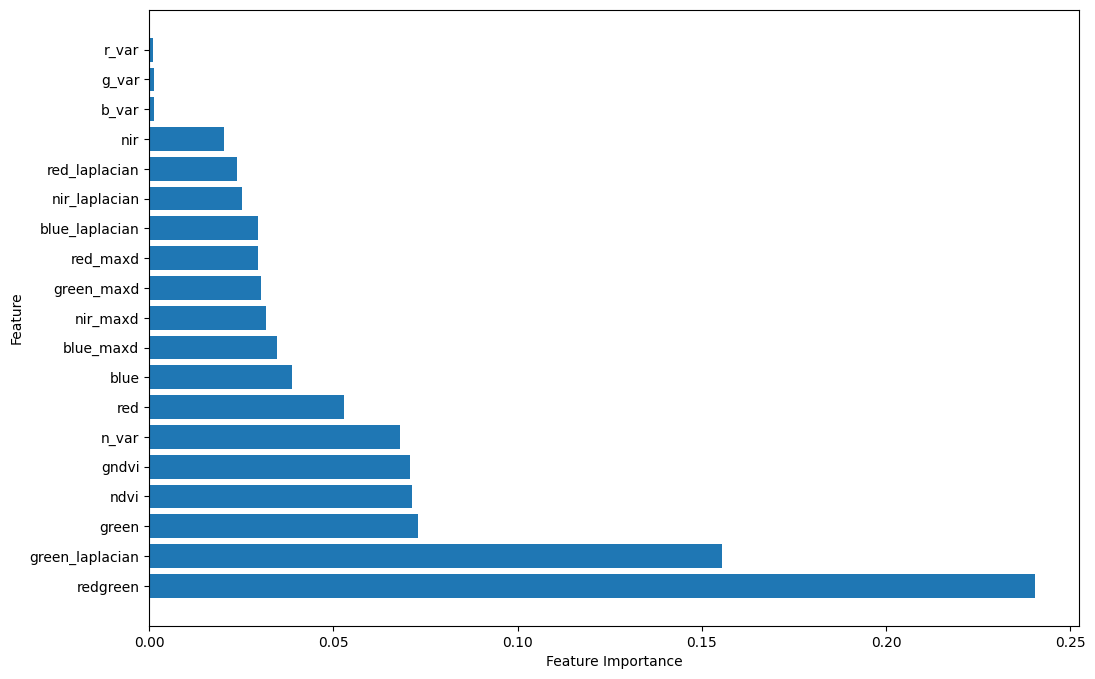

In [25]:
rank = []
plt.clf()

fig, ax = plt.subplots(figsize=(12, 8))

for f in range(bcount): 
    print(f"{f+1}. {X.columns[imp[f]]}: {importances[imp[f]]}")
    rank.append(X.columns[imp[f]])
# Plot the top feature importances in a horizontal bar chart
plt.barh(range(bcount), importances[imp], align="center")
plt.yticks(range(bcount), X.columns[imp])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
fig.savefig(out_fn + 'feat_importance_all.png')

In [26]:
# select top features
num_features = 16
top_indices = imp[:num_features]
top_importances = importances[top_indices]

Top feature rankings:
1. redgreen: 0.24042650366820797
2. green_laplacian: 0.15554898314625162
3. green: 0.07294531931799632
4. ndvi: 0.07140021358078823
5. gndvi: 0.07087480577137513
6. n_var: 0.06815525051848259
7. red: 0.05293514577747384
8. blue: 0.03867421867405426
9. blue_maxd: 0.03464583766748461
10. nir_maxd: 0.03179897380867317
11. green_maxd: 0.03037881543927446
12. red_maxd: 0.029628624399487755
13. blue_laplacian: 0.02951580678573612
14. nir_laplacian: 0.025272942221867274
15. red_laplacian: 0.023934796639644082
16. nir: 0.020279259147447232


<Figure size 640x480 with 0 Axes>

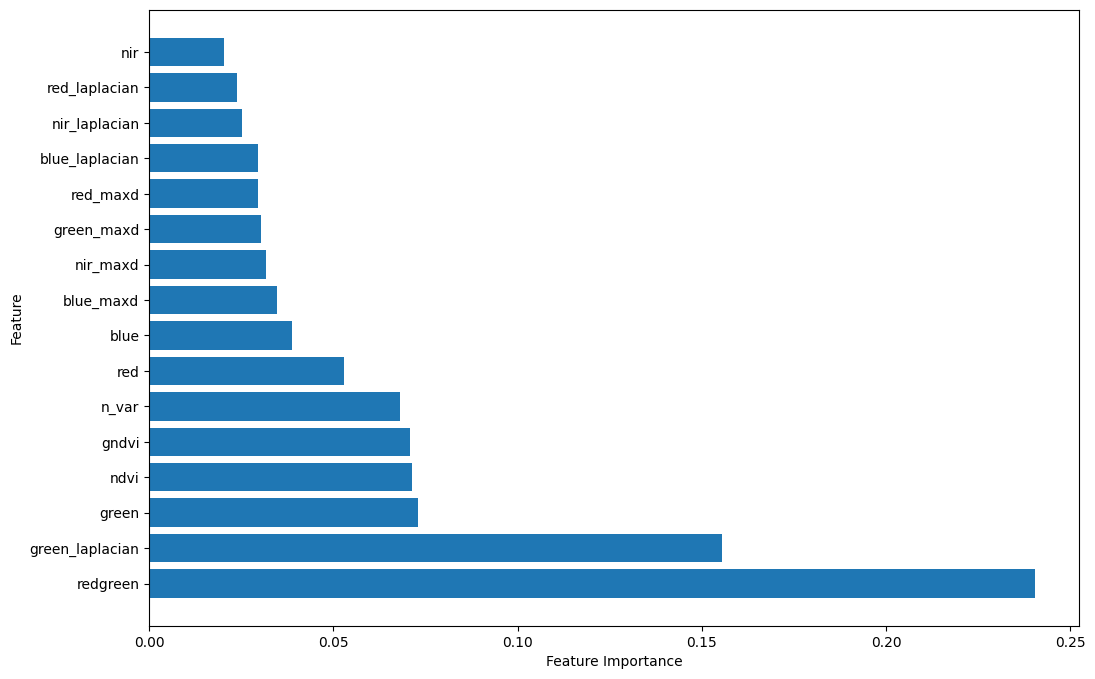

In [27]:
# Print the top  feature rankings - understand which features impact the outcome the most
top_rank = [] # create list to store these top features
plt.clf()
fig, ax = plt.subplots(figsize=(12, 8))

print("Top feature rankings:")
for f in range(num_features):  # Use num_features instead of 10
    print(f"{f+1}. {X.columns[imp[f]]}: {importances[imp[f]]}")
    top_rank.append(X.columns[imp[f]])
# Plot the top feature importances in a horizontal bar chart
plt.barh(range(num_features), top_importances, align="center")
plt.yticks(range(num_features), X.columns[top_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()
fig.savefig(out_fn + 'feat_select_7.png')

Update gcp training data, select only the top ranked variables (p>0.02) based on the top_rank index

In [28]:
# subset training data (gcp)
# add in class column to list
top_rank.append('class') # run once only
sf_set = grid_gdf[top_rank]
sf_set

,redgreen,green_laplacian,green,ndvi,gndvi,n_var,red,blue,blue_maxd,nir_maxd,green_maxd,red_maxd,blue_laplacian,nir_laplacian,red_laplacian,nir,class
0,-0.046676,65244.0,370.0,0.869202,0.857308,12.0,337.0,132.0,529.0,6595.0,6745.0,6745.0,288.0,61073.0,4569.0,4816.0,1.0
1,0.006321,65275.0,786.0,0.584876,0.589020,3.0,796.0,489.0,898.0,2889.0,3123.0,3123.0,288.0,62974.0,2266.0,3039.0,1.0
2,-0.106648,64905.0,799.0,0.722222,0.666945,0.0,645.0,350.0,509.0,3508.0,3793.0,3793.0,501.0,62239.0,3505.0,3999.0,1.0
3,-0.024518,65265.0,585.0,0.834914,0.827332,2.0,557.0,275.0,510.0,6157.0,6413.0,6413.0,291.0,59737.0,5600.0,6191.0,1.0
4,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,-0.124873,65183.0,554.0,0.811255,0.763753,2.0,431.0,214.0,631.0,5151.0,5337.0,5337.0,383.0,62371.0,3814.0,4136.0,2.0
679,-0.125864,65223.0,407.0,0.865618,0.830204,1.0,316.0,189.0,355.0,4461.0,4580.0,4580.0,228.0,61342.0,4171.0,4387.0,2.0
680,-0.126162,65235.0,424.0,0.880080,0.848083,0.0,329.0,190.0,296.0,5145.0,5296.0,5296.0,271.0,60805.0,4969.0,5158.0,2.0
681,-0.188976,65124.0,453.0,0.909144,0.869565,0.0,309.0,193.0,298.0,6328.0,6406.0,6406.0,283.0,59160.0,6334.0,6493.0,2.0


In [29]:
# update col indices for selected features
sf_names = []
for col in sf_set.columns:
  sf_names.append(col)

model_sf_indices = [
    sf_names.index(var_name) for var_name in sf_names[1:]
]

print(model_sf_indices)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [30]:
# convert to numpy array and to scikit-learn nomenclature (can use pandas instead)
X1_sf = (sf_set.drop(columns=['class'])).to_numpy()
y1_sf = sf_set[['class']].to_numpy()[:,0]

In [31]:
# split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X1_sf, y1_sf, test_size = 0.3, random_state = 42, stratify = y
)

Update raster stack with top rank indices. Get top indices to load in raster layers that were top performing indices (p >0.02)

In [32]:
#top_indices
index = (top_indices + 1).tolist()
index

[16, 7, 6, 10, 5, 14, 15, 1, 3, 13, 8, 18, 2, 12, 17, 11]

In [33]:
# read in masked stack and select the bands (since rasterio reads from 1, the list has been increased to 1 as the array indexed these values from 0 (e.g 0=ASM, but with rasterio 1=ASM)
with rio.open(os.path.join(out_fn,'masked_stack.tif')) as src:
    # get metadata from dataset
    bcount = src.count
    tags = src.tags()
    mask_stack = src.read(tuple(index))
    src_meta = src.profile

In [34]:
# change dimension order of array
img = np.transpose(mask_stack,(1,2,0))
img.shape
# reshape numpy to match the image
X_img = img[:,:,:bcount].reshape(-1,img.shape[-1])
print(X_img.shape) # is a numpy ndarray
# (208502721, 17)

(208502721, 16)


#### Random Forest Model

In [35]:
from pprint import pprint

Classifier = RandomForestClassifier
metric = 'balanced_accuracy'

# k-fold cross validation analysis
outer_cv_splits = 2
test_size = 0.30 # fract of dataset set aside

In [36]:
# Create the parameter grid based on the results of random search
param_grid = {
    'class_weight': [None],
    'max_features': ['log2', None],
    'n_estimators': [100, 150, 200, 250, 300],
    'criterion': ['gini']
}

In [37]:
# Generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=42)

clf = GridSearchCV(Classifier(),
                   param_grid,
                   scoring=metric,
                   verbose=1,
                   cv=rs.split(X1_sf, y1_sf))

clf.fit(X1_sf, y1_sf)

print('\n')
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print(f"The {metric} score using these parameters is: ")
print(round(clf.best_score_, 2))

# fits 2 CV folds for each candidate

Fitting 2 folds for each of 10 candidates, totalling 20 fits


The most accurate combination of tested parameters is: 
{'class_weight': None,
 'criterion': 'gini',
 'max_features': 'log2',
 'n_estimators': 200}


The balanced_accuracy score using these parameters is: 
0.88


In [38]:
# run random forest model and train on training samples
rf_model = Classifier(**clf.best_params_, random_state=1)
rf_model.fit(X_train, y_train) 
# ran on monday, completed friday 26/07

RandomForestClassifier(max_features='log2', n_estimators=200, random_state=1)

In [39]:
# run evaluation using test dataset and existing model
rf_model.score(X_test, y_test)
# 0.9024390 - rf model score for 7 feature datasets

0.8878048780487805

In [40]:
X_img.shape # check shape of the final selected variables

(208502721, 16)

In [41]:
# run a prediction and probability
rf_pred = rf_model.predict(X_img)
rf_prob = rf_model.predict_proba(X_img)

In [42]:
# get shape and re-shape
# using exisitng shape from ONE of the input arrays (as loaded earlier)
shp = src.shape
# check shape of prediction then reshape array
rf_pred = rf_pred.reshape(shp)
# select African Tulip Probability (Class 1) - which is 0, and 1 would be other trees
rf_at_prob = rf_prob[:,0]
rf_at_prob = rf_at_prob.reshape(shp)

In [43]:
ras_meta = src_meta
ras_meta.update(count = 1)
output_fn = 'C:/Data/atulip/ws/subset_area/site0/spectral/output/'

In [44]:
# write raster dataset to file
with rio.open(os.path.join(output_fn + 'rf_pred.tif'), 'w', **ras_meta) as dst:
    dst.write(rf_pred, indexes = 1)
    
with rio.open(os.path.join(output_fn + 'rf_prob.tif'), 'w', **ras_meta) as dst:
    dst.write(rf_at_prob, indexes = 1)

In [45]:
# import RF predicted via rasterio
rf_pred = rio.open(os.path.join(output_fn + 'rf_pred.tif'))
rf_pred = rf_pred.read()
rf_pred = rf_pred[0,:,:]

In [46]:
# import RF probability via rasterio
rf_prob = rio.open(os.path.join(output_fn + 'rf_prob.tif'))
rf_prob = rf_prob.read()
rf_prob = rf_prob[0,:,:]

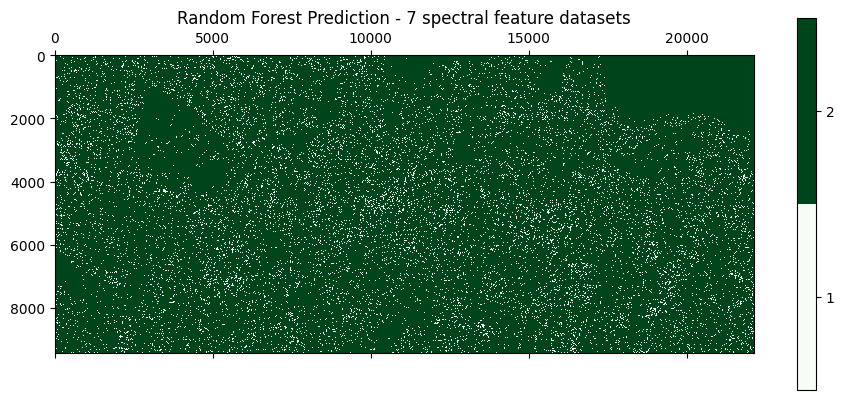

In [47]:
# define function to map raster values as discrete values
def discrete_matshow(data):
    #get discrete colormap
    cmap = plt.get_cmap('Greens', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap, vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

discrete_matshow(rf_pred)
plt.title('Random Forest Prediction - 7 spectral feature datasets')
plt.savefig(output_fn + 'rf_prob.png', bbox_inches = 'tight')

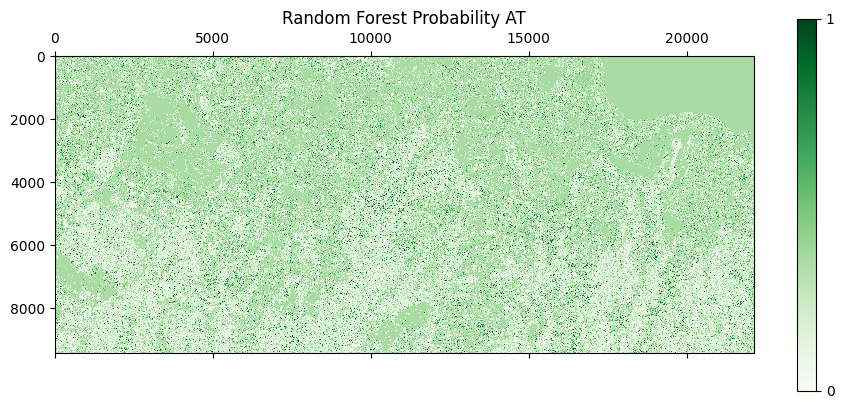

In [48]:
# show mask results
def probability_matshow(data):
    #get discrete colormap
    # cmap = plt.get_cmap('Greens', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap='Greens', vmin = 0.0, vmax = 1)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))

probability_matshow(rf_at_prob)
plt.title('Random Forest Probability AT')
plt.savefig(output_fn + 'rf_at_pred.png', bbox_inches = 'tight')

#### Evaluating Random Forest Model
Using the available tutorial (https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56) and sklearn metrics, produce confusion matrix, plot matrix and generate classification report from predicted model.

In [49]:
# generate confusion matrix heatmap using seaborn
import seaborn as sns

In [50]:
# predict on the test dataset
y_pred_test = rf_model.predict(X_test)

In [51]:
accuracy_score(y_test, y_pred_test)

0.8878048780487805

In [52]:
at_matrix = confusion_matrix(y_test, y_pred_test)
at_matrix = at_matrix.astype('float')/at_matrix.sum(axis = 1)[:, np.newaxis] # reshape confusion matrix data

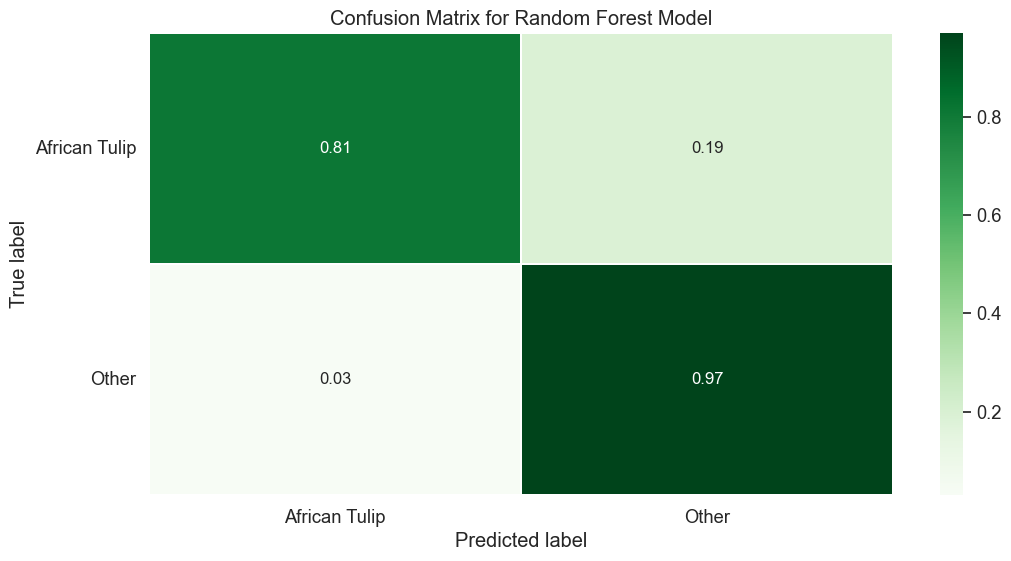

In [53]:
# build plot
plt.figure(figsize = (12,6))
sns.set(font_scale = 1.2)
sns.heatmap(at_matrix, annot = True, annot_kws = {'size':12}, cmap = plt.cm.Greens, linewidth = 0.01)

# Add labels to the plot
class_names = ['African Tulip', 'Other']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
# plt.show()
plt.savefig(output_fn + 'rf_confusion_matrix.png', bbox_inches = 'tight')

In [54]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         1.0       0.97      0.81      0.88       105
         2.0       0.83      0.97      0.89       100

    accuracy                           0.89       205
   macro avg       0.90      0.89      0.89       205
weighted avg       0.90      0.89      0.89       205



#### XGBoost Model

In [55]:
import xgboost as xgb

In [56]:
# pandas dataframe rather than numpy (req. by scikit)
X1 = sf_set.drop('class', axis = 1)
y1 = sf_set['class']

In [57]:
# convert lables into binary values
y1_sf[y1 ==2] = 0 # other species
y1_sf[y1 ==1] = 1 # african tulip

In [58]:
# split X and y into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X1, y1_sf, test_size = 0.3, random_state = 0, stratify = y)

In [59]:
# define data matrix
data_dmatrix = xgb.DMatrix(data = X1, label = y1_sf)

In [60]:
# run cross-validation grid search

grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6,7,8], 
    'learning_rate': [0.1, 0.5]
}
# Grid search function
CV_xgb = GridSearchCV(estimator = xgb.XGBClassifier(),
                      param_grid = grid,
                      cv = 5)
CV_xgb.fit(X_train, y_train)

print(CV_xgb.best_params_)

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


In [61]:
# copy parameters and add objective
params = {
    'objective': 'binary:logistic','learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 200
}

In [62]:
#  train XG Boost Classifier
# instantiate classifier
xgb_clf = xgb.XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:
xgb_pred = xgb_clf.predict(X_img)

In [64]:
xgb_prob = xgb_clf.predict_proba(X_img)

In [65]:
# reshape prediction
xgb_pred = xgb_pred.reshape(shp)
xgb_at_prob = xgb_prob[:,1]
xgb_at_prob = xgb_at_prob.reshape(shp)

In [66]:
# write prediction of xgboost
with rio.open(os.path.join(output_fn + 'xbg_pred.tif'), 'w', **ras_meta) as dst:
    dst.write(xgb_pred, indexes = 1)
with rio.open(os.path.join(output_fn + 'xbg_prob.tif'), 'w', **ras_meta) as dst:
    dst.write(xgb_at_prob, indexes = 1)  

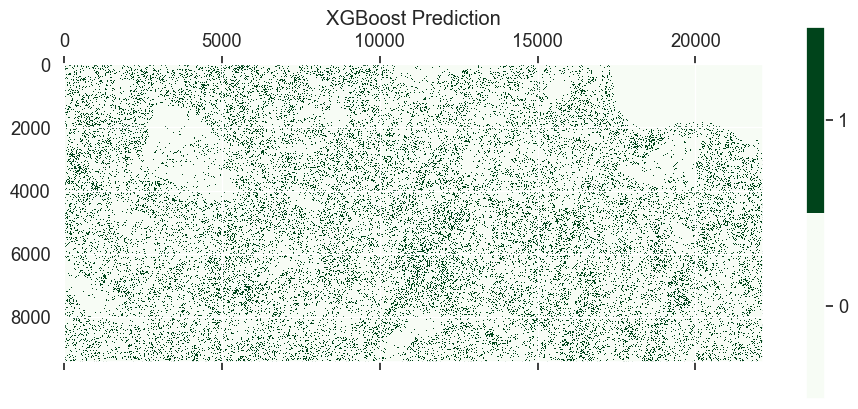

In [67]:
# derive a function and plot the discrete prediction of the African tulip
def discrete_matshow(data):
    #get discrete colormap
    cmap = plt.get_cmap('Greens', np.max(data)-np.min(data)+1)
    # set limits .5 outside true range
    mat = plt.matshow(data,cmap=cmap, vmin = np.min(data)-.5, vmax = np.max(data)+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.min(data),np.max(data)+1))


discrete_matshow(xgb_pred)
plt.title('XGBoost Prediction')
plt.savefig(output_fn + 'xgboost_at_pred.png', bbox_inches = 'tight')

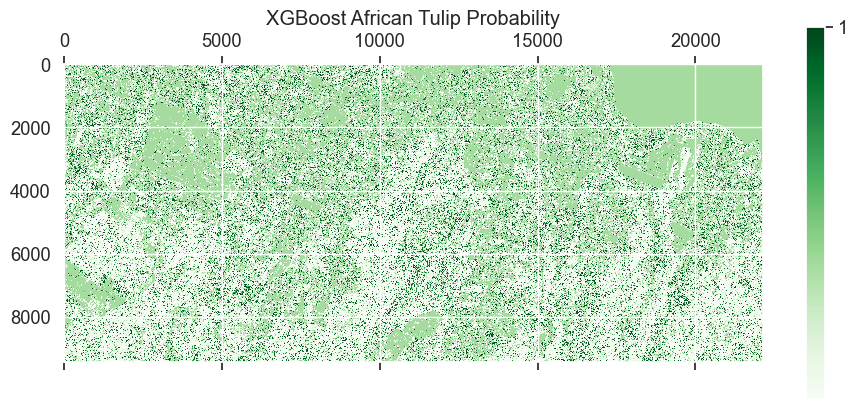

In [68]:
def probability_matshow(data):
    mat = plt.matshow(data,cmap='Greens', vmin = 0, vmax = 1)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(1,np.max(data)+1))
    
probability_matshow(xgb_at_prob)
plt.title('XGBoost African Tulip Probability')
plt.savefig(output_fn + 'xgboost_at_prob.png', bbox_inches = 'tight')

#### Check accuracy score for XGBoost Model

In [69]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test)

In [70]:
# check accuracy score
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
# 0.7982 (with 300 gcp)
# 0.8982 (with 1000+ gcp)

XGBoost model accuracy score: 0.9171


In [71]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float')/matrix.sum(axis = 1)[:, np.newaxis] # reshape confusion matrix data

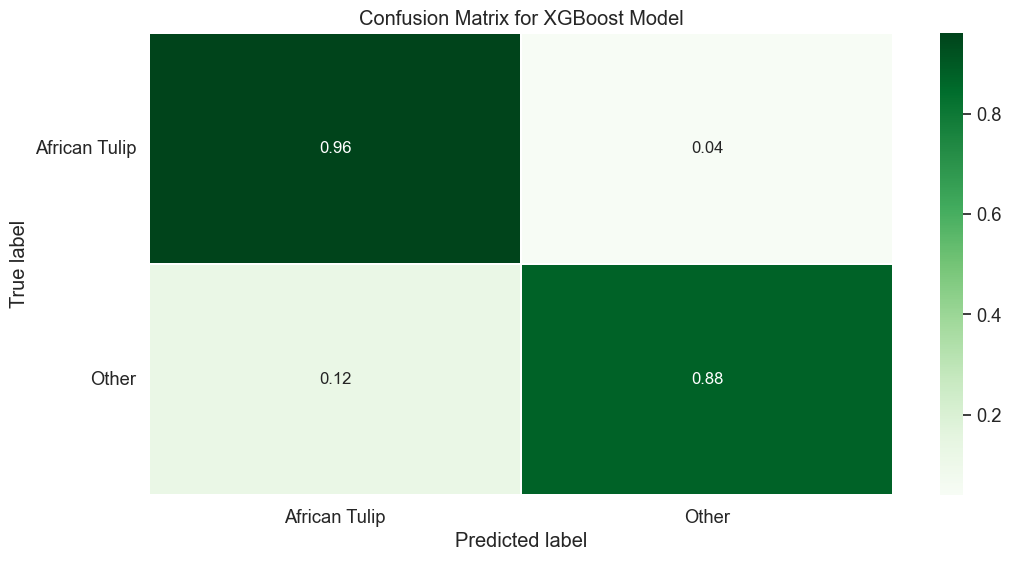

In [72]:
# build plot
plt.figure(figsize = (12,6))
sns.set(font_scale = 1.2)
sns.heatmap(matrix, annot = True, annot_kws = {'size':12}, cmap = plt.cm.Greens, linewidth = 0.01)

# Add labels to the plot
class_names = ['African Tulip', 'Other']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XGBoost Model')
# plt.show()
plt.savefig(output_fn + 'xgboost_confusion_matrix.png', bbox_inches = 'tight')

In [73]:
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE of the XGBoost model: {rmse:.3f}")

RMSE of the XGBoost model: 0.083


In [74]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       100
         1.0       0.48      0.40      0.44       105
         2.0       0.00      0.00      0.00         0

    accuracy                           0.20       205
   macro avg       0.16      0.13      0.15       205
weighted avg       0.24      0.20      0.22       205



C:\Users\c3372111\.conda\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c3372111\.conda\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c3372111\.conda\envs\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\c33721

##### k-fold Cross Validation using XGBoost

In [75]:
from xgboost import cv

#params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

C:\Users\c3372111\.conda\envs\myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\c3372111\.conda\envs\myenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:23:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [76]:
xgb_cv.head() # contains auc metrics for each boosting roung. Preview xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.964617,0.005431,0.909377,0.006659
1,0.974520,0.003856,0.918934,0.004516
2,0.982181,0.001779,0.924860,0.007799
3,0.985579,0.001357,0.926296,0.007901
4,0.986365,0.000866,0.929856,0.005596


<Figure size 640x480 with 0 Axes>

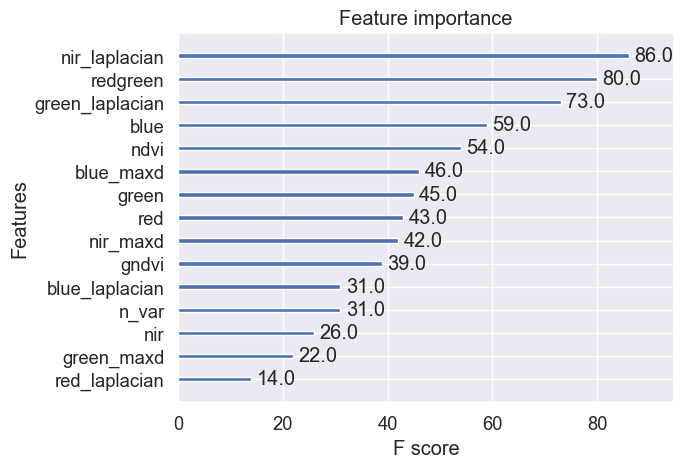

In [77]:
plt.clf()
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = (10, 8)
# plt.show()
plt.savefig(output_fn + 'feature_imp_xgboost.png', bbox_inches = 'tight')